In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, average_precision_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
#Hyper parameter
batch_size = 64
num_classes = 10
learning_rate = 0.001
num_epochs = 2

**Load the KMNIST Data**

In [13]:
transform = transforms.Compose([transforms.Resize((32,32)),transforms.ToTensor()])

In [15]:
train_dataset = torchvision.datasets.KMNIST(root = './data',
                                           train = True,
                                           transform = transform,
                                           download = True)



In [16]:
test_dataset = torchvision.datasets.KMNIST(root = './data',
                                          train = False,
                                          transform = transform,
                                          download=True)

In [17]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)


test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

In [18]:
for X, y in train_loader:
  print(X.shape)
  break

torch.Size([64, 1, 32, 32])


**LeNet-5 Model**

In [53]:

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv_layers= nn.Sequential(
            nn.Conv2d(3,64,3), # 1st layer
            nn.ReLU(),
            nn.AvgPool2d(2,2),

            nn.Conv2d(64,128,3),# 2nd layer
            nn.ReLU(),
            nn.AvgPool2d(2,2),

            nn.Conv2d(128,256,3),  # 3rd layer
            nn.ReLU(),
            nn.AvgPool2d(2,2),

            nn.Conv2d(256,512,3), #4th layer
            nn.ReLU(),
            nn.AvgPool2d(2,2),

            nn.Conv2d(512,512,3), # 5th layer
            nn.ReLU(),
            nn.AvgPool2d(2,2)


        )


        self.fc_layers= nn.Sequential(
            nn.Linear(512*4*4, 4096), # 1st layer
            nn.LeakyReLU(),
            nn.Linear(4096,2048), # 2nd layer
            nn.ReLU(),
            nn.Linear(2048,1024), #3rd layer
            nn.ReLU(),
            nn.Linear(1024,10),  #4th layer
            nn.ReLU(),
            nn.Linear(84,num_classes),


        )




    def forward(self, x):
        x= self.conv_layers(x)
        x= x.reshape(x.shape[0], -1)
        x= self.fc_layers(x)
        return x

In [39]:
model = LeNet()
model.to(device)

LeNet(
  (conv_layers): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)

**Loss and optimizer**

In [40]:
loss_fn = nn.CrossEntropyLoss() #mulitclass
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

**Train the model**

In [41]:
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        outputs = model(images)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 400 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
        		           .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/2], Step [400/938], Loss: 0.5011
Epoch [1/2], Step [800/938], Loss: 0.3302
Epoch [2/2], Step [400/938], Loss: 0.3245
Epoch [2/2], Step [800/938], Loss: 0.1589


**Accuracy**

In [42]:
true_labels = [] #for confusion matrix
predicted_labels = [] #for confusion matrix

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy= 100 * correct / total
    print('Accuracy of the network on the 10000 test images: {} %'.format(accuracy))
    top1_error = 100 - accuracy
    print('Top-1 Error: {} %'.format(top1_error))



Accuracy of the network on the 10000 test images: 87.53 %
Top-1 Error: 12.469999999999999 %


**Confusion matrix**

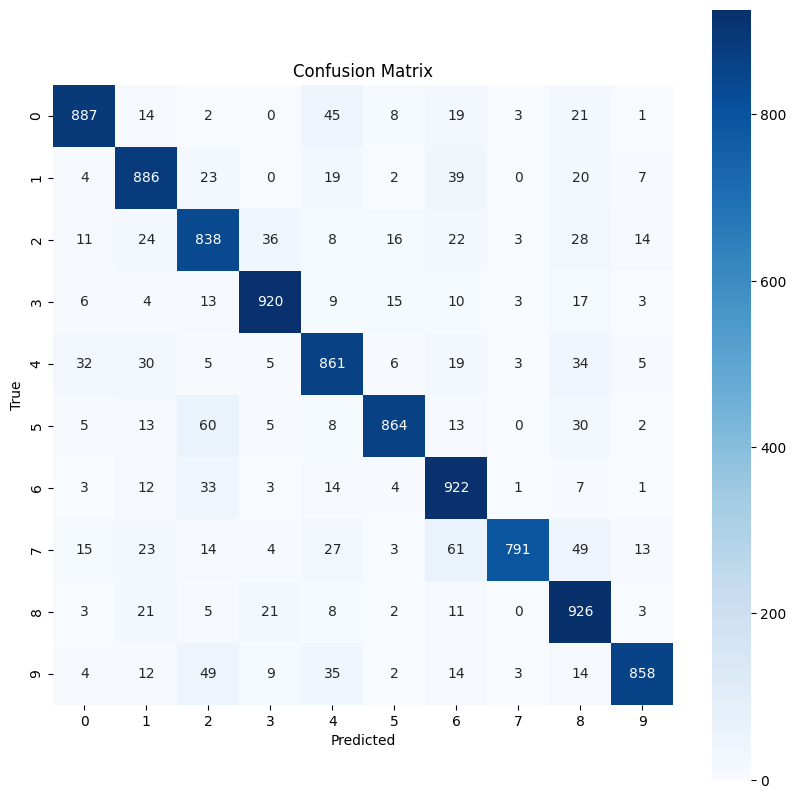

In [43]:
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)
confusion = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(num_classes, num_classes))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', square=True, xticklabels=True, yticklabels=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

**Classification report**

In [44]:
report = classification_report(true_labels, predicted_labels)
print('\n'+ report)


              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1000
           1       0.85      0.89      0.87      1000
           2       0.80      0.84      0.82      1000
           3       0.92      0.92      0.92      1000
           4       0.83      0.86      0.85      1000
           5       0.94      0.86      0.90      1000
           6       0.82      0.92      0.87      1000
           7       0.98      0.79      0.88      1000
           8       0.81      0.93      0.86      1000
           9       0.95      0.86      0.90      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [45]:
# Calculate precision, recall, f1 score
precision = precision_score(true_labels, predicted_labels, average=None)
recall = recall_score(true_labels, predicted_labels, average=None)
f1 = f1_score(true_labels, predicted_labels, average=None)


for class_label in range(10):
    print(f'Class {class_label}:')
    print(f'Precision: {precision[class_label]:.2f}')
    print(f'Recall: {recall[class_label]:.2f}')
    print(f'F1-score: {f1[class_label]:.2f}')
    print()


Class 0:
Precision: 0.91
Recall: 0.89
F1-score: 0.90

Class 1:
Precision: 0.85
Recall: 0.89
F1-score: 0.87

Class 2:
Precision: 0.80
Recall: 0.84
F1-score: 0.82

Class 3:
Precision: 0.92
Recall: 0.92
F1-score: 0.92

Class 4:
Precision: 0.83
Recall: 0.86
F1-score: 0.85

Class 5:
Precision: 0.94
Recall: 0.86
F1-score: 0.90

Class 6:
Precision: 0.82
Recall: 0.92
F1-score: 0.87

Class 7:
Precision: 0.98
Recall: 0.79
F1-score: 0.88

Class 8:
Precision: 0.81
Recall: 0.93
F1-score: 0.86

Class 9:
Precision: 0.95
Recall: 0.86
F1-score: 0.90

